# Few-shot prompting for ARC24 Challenge

## Goal

How far can we get by simply using few-shot prompting with LLMs?

Questions to answer:

- **What is the maximum context lenght that we can use at inference?** 61k tokens when using VLLM and phi-3
- **What is the best way to encode the grids?** Use a minimal encoding to reduce token usage
- **What is the effect of using a bigger number of examples?** Phi-3 does not benefit from using few-shot prompting
- **Does giving a text description of the task helps?** Phi-3 does not benefit from including text description in the few-shot examples
- **What is the best LLM for this task?** So far Llama 3 has been the only model capable of solving one test task.

## Results

### Zero-shot baseline

On a first step I have tried a very simple baseline where I give input grids to the assistant and
the assistant replies with the output for each grid. This is done with all the train samples until
we give the test input and use the response of the model as the prediction.
In addition I also use data augmentations (flips and rotations) to make up to two predictions for each task.
The data augmentation is also useful because sometimes the prediction of the model is invalid, so we have to make multiple predictions to have 2 valid responses.

| train | evaluation | test |
|-------|------------|------|
| 6.40% | 2.50%      | 0%   |

This approach is able to solve some of the train and evaluation task, but it does not solve any of the test tasks.

### Few-shot results

Using samples from the evaluation dataset I have evaluated the effect of using few-shot prompting. In this case
I have changed the prompt style: the user shows input-output pairs to the assistant and then requests the assistant
to predict the output given some input.

| n shots | accuracy | correct_pixels | correct_size | unanswered |
|---------|----------|----------------|--------------|------------|
| 0       | 5.80%    | 55.10%         | 73.50%       | 17.40%     |
| 1       | 4.50%    | 44.80%         | 61.00%       | 23.60%     |
| 2       | 4.80%    | 37.70%         | 54.40%       | 29.80%     |
| 4       | 2.50%    | 22.40%         | 33.10%       | 33.10%     |
| 8       | 2.30%    | 23.10%         | 35.50%       | 36.80%     |

The results show that Phi-3 does not benefit from few-shot prompting with ARC tasks. As we give more
examples the results get worse.

### Add reasoning

I have manually described with text the transformation of some of the evaluation tasks. Then repeat
the few-shot experiment but adding the reasoning before creating the grid.

| uses reasoning | accuracy | correct_pixels | correct_size | unanswered |
|----------------|----------|----------------|--------------|------------|
| No             | 2.50%    | 22.40%         | 33.10%       | 33.10%     |
| Yes            | 1%       | 19%            | 30.70%       | 42.50%     |

The model does not understand the puzzles. The examples and reasoning are not useful

### Different models, zero-shot

Since the best results were obtained for the 0-shot setup, I could try using different models.
I can make submissions without using compute time, so I could see if some of the models is able
to solve some task from the test set.

| model      | test |
|------------|------|
| Phi-3      | 0    |
| Mistral 7b | 0    |
| Llama 3 8b | 1    |
| Llama 3.1 8b | 0    |

Llama 3 is able to solve one of the tasks from the test set. To better compare the models I should
evaluate them on the public data, but I don't have Kaggle compute available.

## Conclusion

Few-shot or zero-shot inference with current LLMs is not the way to solve the ARC challenge.
The performance is very poor.

## References

### Notebooks

- https://www.kaggle.com/code/ironbar/2xvllm-with-code-interpreter
- https://www.kaggle.com/code/ironbar/autobots-roll-out/notebook

### Models

- https://huggingface.co/microsoft/Phi-3-mini-128k-instruct
- https://huggingface.co/blog/kv-cache-quantization
- https://www.reddit.com/r/LocalLLaMA/comments/1e0kkgk/hardware_requirements_for_phi3_mini_and_phi3/
- https://www.reddit.com/media?url=https%3A%2F%2Fpreview.redd.it%2Fmicrosoft-phi-3-3-8b-with-128k-context-released-on-hf-v0-h2xzg8vaigwc1.jpeg%3Fwidth%3D1734%26format%3Dpjpg%26auto%3Dwebp%26s%3Dec27de7bd97a90a4c44ff95c561ce8008ce7aed3
- https://huggingface.co/docs/transformers/main/en/chat_templating

> The Phi-3-Mini-128K-Instruct is a 3.8 billion-parameter, lightweight, state-of-the-art open model trained using the Phi-3 datasets. 

## Learnings

### Phi-3 with transformers

If I load the phi-3 model with `torch_dtype="auto"` and `device_map="balanced"` it uses 3.7 GB of GPU memory on each device. It is able to handle an input of 4000 tokens using 13.4/15 GB of memory.

This is a very small context window compared to the 128k that the model is able to handle.

> ValueError: This model does not support the quantized cache. If you want your model to support quantized cache, please open an issue.

### Phi-3 with VLLM

It works with `vllm=0.5.3.post1` and `vllm-0.5.1`

I had to use `vllm-0.5.1` to make it work, other versions didn't worked so far. I was able to run VLLM with `Phi-3-mini-128k-instruct` and a context size of 61k by using `kv_cache_dtype='fp8_e5m2'`.

That is far from the 128k context size of the model, but much better than the 4k tokens when using transformers. Futhermore this [plot](https://www.reddit.com/media?url=https%3A%2F%2Fpreview.redd.it%2Fmicrosoft-phi-3-3-8b-with-128k-context-released-on-hf-v0-h2xzg8vaigwc1.jpeg%3Fwidth%3D1734%26format%3Dpjpg%26auto%3Dwebp%26s%3Dec27de7bd97a90a4c44ff95c561ce8008ce7aed3) says that a context size bigger than 44k does not work well.

#### What didn't work

I can makek it work with `vllm==0.4.3` and `Phi-3-mini-4k-instruct` with 4000 input tokens. However with `Phi-3-mini-128k-instruct` I get this error: 

```
File /opt/conda/lib/python3.10/site-packages/vllm/config.py:1224, in _get_and_verify_max_len(hf_config, max_model_len, disable_sliding_window, sliding_window_len)
   1217 if disable_sliding_window:
   1218     # TODO(robertgshaw): Find a model that supports rope_scaling
   1219     # with sliding window to see if this case should be allowed.
   1220     raise NotImplementedError(
   1221         "Disabling sliding window is not supported for models "
   1222         "with rope_scaling. Please raise an issue so we can "
   1223         "investigate.")
-> 1224 assert "factor" in rope_scaling
   1225 scaling_factor = rope_scaling["factor"]
   1226 if rope_scaling["type"] == "yarn":

AssertionError: 
```

If I use `vllm-0.5.2` I get the same error for both models:

```
AttributeError: '_OpNamespace' '_C' object has no attribute 'rms_norm'
```

If I use `vllm-0.5.1` it works for the 4k model. The 128k model gives OOM error.

I try then using `tensor_parallel_size=2` and get this error:

```
# `tensor_parallel_size=2` 
ValueError: The model's max seq len (64000) is larger than the maximum number of tokens that can be stored in KV cache (30528). Try increasing `gpu_memory_utilization` or decreasing `max_model_len` when initializing the engine.
# `tensor_parallel_size=2` and kv_cache_dtype='fp8_e5m2',
ValueError: The model's max seq len (64000) is larger than the maximum number of tokens that can be stored in KV cache (61072). Try increasing `gpu_memory_utilization` or decreasing `max_model_len` when initializing the engine.
```

#### Getting the same output as with transformers

I have verified that if I apply the chat template before calling the model, and if I don't use kv cache quantization I get the [exact same response](https://www.kaggle.com/code/ironbar/phi-3-sample-code?scriptVersionId=188682799) to the default messages in the model documentation:

```
 To solve the equation 2x + 3 = 7, follow these steps:

1. Subtract 3 from both sides of the equation:
   2x + 3 - 3 = 7 - 3
   2x = 4

2. Divide both sides of the equation by 2:
   2x/2 = 4/2
   x = 2

So, the solution to the equation 2x + 3 = 7 is x = 2.
```

### First experiments

Using a basic grid encoder already uses 8k tokens in the worst case. (`30x30x2x4=7200`)
Thus an encoder that uses excel notation (A1, B2...) will use at least 3 times more tokens. 

## Configuration

In [14]:
class cfg:
    # Model
    #model_path = '/kaggle/input/phi-3/transformers/phi-3-mini-128k-instruct/1/Phi-3-mini-128k-instruct'
    #model_path = '/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1'
    #model_path = '/kaggle/input/llama-3/transformers/8b-chat-hf/1'
    model_path = '/kaggle/input/llama-3.1/transformers/8b-instruct/1'
    # model_path = '/kaggle/input/llama-3.2/transformers/3b-instruct/1'
    max_model_len = 8192 #61000 for phi-3
    # Dataset
    # dataset_path = '/kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
    #dataset_path = '/kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json'
    dataset_path = '/kaggle/input/arc-prize-2024/arc-agi_test_challenges.json'
    n_tasks = None # Optional parameter to limit the number of task in the inference, set it to None to use all the tasks
    # Few-shot
    few_shot_dataset_path = '/kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json'
    n_shots = 0
    # Inference params
    max_predictions_per_task = 2 # 
    sampling_params = dict(temperature=0.0, max_tokens=2000) # https://docs.vllm.ai/en/latest/dev/sampling_params.html

In [15]:
import os
is_dry_run = cfg.dataset_path == '/kaggle/input/arc-prize-2024/arc-agi_test_challenges.json' and not os.getenv('KAGGLE_IS_COMPETITION_RERUN')
is_dry_run = False
if is_dry_run:
    print('This is a dry run, no inference nor installation of packages will be done')

## Install

In [16]:
%%time
if not is_dry_run:
    try:
        import vllm
    except ImportError:
        !pip uninstall -q -y torch
        !pip install -q --no-index --find-links=/kaggle/input/making-wheels-of-necessary-packages-for-vllm vllm
    # model imports
    from vllm import LLM, SamplingParams
    from transformers import AutoTokenizer

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.6.1 requires cubinlinker, which is not installed.
cudf 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.6.1 requires ptxcompiler, which is not installed.
cuml 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 16.1.0 which is incompatible.
cudf 24.6.1 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.5.0 which is incompatible.
jupyterlab 4.2.3 req

2024-11-05 22:35:05,167	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


CPU times: user 4.54 s, sys: 718 ms, total: 5.26 s
Wall time: 2min 24s


## Imports

In [17]:
from abc import ABC, abstractmethod
import json
import os
from tqdm.auto import tqdm
import numpy as np
from itertools import islice, product
import matplotlib.pyplot as plt
from matplotlib import colors
from termcolor import colored

## Code

## Grid encoding

There are many ways to encode/format the grid as input to the LLM. In this section we are going to define several encoders so we can sistematically try them all.

In [18]:
class GridEncoder(ABC):
    @abstractmethod
    def to_text(self, grid):
        pass
    
    @abstractmethod
    def to_grid(self, text):
        pass

In [19]:
sample_grid = np.eye(3, dtype=int).tolist()

def test_translator(translator):
    assert sample_grid == translator.to_grid(translator.to_text(sample_grid))
    print(translator.to_text(sample_grid))

In [20]:
class MinimalGridEncoder(GridEncoder):
    @staticmethod
    def to_text(grid):
        text = '\n'.join([''.join([str(x) for x in line]) for line in grid])
        return text
    
    @staticmethod
    def to_grid(text):
        lines = text.strip().splitlines()
        grid = [[int(x) for x in line] for line in lines]
        return grid
        
test_translator(MinimalGridEncoder())

100
010
001


In [21]:
class GridWithSeparationEncoder(GridEncoder):
    def __init__(self, split_symbol):
        self.split_symbol = split_symbol

    def to_text(self, grid):
        text = '\n'.join([self.split_symbol.join([str(x) for x in line]) for line in grid])
        return text
    
    def to_grid(self, text):
        lines = text.strip().splitlines()
        grid = [[int(x) for x in line.split(self.split_symbol)] for line in lines]
        return grid
        
test_translator(GridWithSeparationEncoder('|'))

1|0|0
0|1|0
0|0|1


In [22]:
class GridCodeBlockEncoder(GridEncoder):
    def __init__(self, base_encoder):
        self.encoder = base_encoder
    
    def to_text(self, grid):
        text = f'```grid\n{self.encoder.to_text(grid)}\n```'
        return text
    
    def to_grid(self, text):
        grid_text = text.split('```grid\n')[1].split('\n```')[0]
        grid = self.encoder.to_grid(grid_text)
        return grid
        
test_translator(GridCodeBlockEncoder(MinimalGridEncoder()))

test_translator(GridCodeBlockEncoder(GridWithSeparationEncoder('|')))

```grid
100
010
001
```
```grid
1|0|0
0|1|0
0|0|1
```


### Prompting

There are also many ways to build a prompt for the ARC challenge. The class that builds the prompt will receive a grid encoder as input, this way we can try different prompts with different grid encoders. 
The class that builds the prompts needs to be also capable of parsing the response from the model.

In [23]:
class PromptCreator(ABC):
    def __init__(self, grid_encoder: GridEncoder):
        self.grid_encoder = grid_encoder
    
    @abstractmethod
    def create_task_prompts(self, task):
        pass
    
    @abstractmethod
    def parse_response(self, text):
        pass

In [24]:
class SimplePromptCreator(PromptCreator):

    def create_task_prompts(self, task):
        if cfg.model_path == '/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1':
            # Mistral does not have system prompt
            messages = []
        else:
            messages = [ 
                {"role": "system", "content": "You are a helpful AI assistant. Your task is to answer to the user using always the same transformation of the user input."}, 
            ] 
        for sample in task['train']:
            messages.append({"role": "user", "content": f"Input:\n{self.grid_encoder.to_text(sample['input'])}"})
            messages.append({"role": "assistant", "content": f"Output:\n{self.grid_encoder.to_text(sample['output'])}"})

        prompts = []
        for test_sample in task['test']:
            final_message = {"role": "user", "content": f"Input:\n{self.grid_encoder.to_text(test_sample['input'])}"}
            prompt = tokenizer.apply_chat_template(messages + [final_message],
                                                   tokenize=False,
                                                   add_generation_prompt=True)
            prompts.append(prompt)
        return prompts
    
    def parse_response(self, text):
        grid_text = text.split('Output:\n')[1]
        return self.grid_encoder.to_grid(grid_text)

In [25]:
puzzle_explanations = {
    '00576224': """The pattern of the input is repeated to generate the output.

1. The first two rows are obtained by simply repeating the 2x2 pattern 3 times along the cols axis.
2. The following two rows are obtained by flipping the pattern horizontally and repeating it 3 times
3. The final two rows are identical to the first ones, simply repeat the 2x2 pattern 3 times.

Thus the output is 3 times bigger than the input (6x6 vs 2x2) because the pattern is repeated 3 times in the row and col axis.""",
    '009d5c81': """To create the output we have to copy the input with two modifications:

1. The object with color 1 is removed and replaced with the background color 0
2. The color of the other object (there are only two objects in the grid) is modified.
  The new color of this object depends on the shape of the object of color 1. There is a mapping
  between shapes and colors. Just look at the train examples for an object of the same shape
  and see the color that is applied on the output.""",
    '00dbd492': """The input shows a square with color 2 that is empty except from a point in the center.
The output is created by colorizing the inside of the square. The color is chosen depending on the size of the squares.
The larger square is painted with 3, the medium with 4 and the small with 8.""",
    '03560426': """The input shows objects of different colors at the bottom of the grid.
The output is created by moving the objects to the top left corner. The objects are moved from left to right order.
The first object is placed at the top left corner, the second object is placed at the lower right corner of the first object,
the third object is placed at the lower right corner of the second object and so on. There is oclusion between the objects,
in those oclusions we see the rightmost object.""",
    '0607ce86': """This is a denoising task. The input shows the same object repeated many times, but there are noisy pixels in the grid.
The output is created by removing all the noise in the grid. The background should be completely 0.
The real object without noise can be guessed because there are many repetitions of the object, so we simply have to
look at the majority pixel on each location.""",
    '0692e18c': """The ouptut is created following this steps.

1. The input is upscaled x3. So if the input is 3x3 the output should be an upscaled version of the input 9x9
2. We apply an AND function in a sliding window fashion over the output using the inverted input pattern (take the input and swicth the background color 0 with the other color and viceversa)
    """,
    '070dd51e': """The output is created by simply drawing horizontal and vertical lines between cells with the same color.
If there is an intersection between lines the vertical line will be shown.""",
    '08573cc6': """The output is created by drawing an spiral that starts at the cell with color 1.
The colors of the spiral are taken from the first two cells of the grid, which will be removed in the output.""",
    '0a2355a6': """The output is created by copying the input and changing the color of the objects.
The new color will be chosen depending on the number of holes of the object. There is a mapping between number of holes and color that can be observed from the input examples.""",
}

In [26]:
class FewShotPromptCreator(PromptCreator):
    task_description = """You are a helpful AI assistant. Your job is to solve tasks from the Abstraction and Reasoning Challenge (ARC). 
The user will present you with sample input and output grids for each task. 
Your job will be to understand the transformation between the input and the output and apply it to the last input grid given by the user. 
The puzzle-like inputs and outputs present a grid where each square can be one of ten colors. A grid can be any height or width between 1x1 and 30x30.
The background of the grid is typically colored with 0.
The tasks from ARC are based on the following priors:

- Objectness: Objects persist and cannot appear or disappear without reason. Objects can interact or not depending on the circumstances.
- Goal-directed: Objects can be animate or inanimate. Some objects are "agents" - they have intentions and they pursue goals.
- Numbers & counting: Objects can be counted or sorted by their shape, appearance, or movement using basic mathematics like addition, subtraction, and comparison.
- Basic geometry & topology: Objects can be shapes like rectangles, triangles, and circles which can be mirrored, rotated, translated, deformed, combined, repeated, etc. Differences in distances can be detected.

The transformations between input and output should be based on these priors.
"""
    def __init__(self, grid_encoder):
        super().__init__(grid_encoder)
        with open(cfg.few_shot_dataset_path, 'r') as f:
            self.few_shot_tasks = json.load(f)
        with open(cfg.few_shot_dataset_path.replace('challenges.json', 'solutions.json'), 'r') as f:
            self.few_shot_solutions = json.load(f)
        self.few_shot_tasks = {task_id: self.few_shot_tasks[task_id] for task_id in puzzle_explanations}
        self.few_shot_solutions = {task_id: self.few_shot_solutions[task_id] for task_id in puzzle_explanations}
        self.few_shot_task_ids = list(self.few_shot_tasks.keys())
        self.n_shots = cfg.n_shots
    
    def create_task_prompts(self, task):
        messages = [{"role": "system", "content": self.task_description}]
        
        for task_id in np.random.choice(self.few_shot_task_ids, self.n_shots):
            few_shot_task = self.few_shot_tasks[task_id]
            user_message = self.create_user_message_for_train_examples(few_shot_task)
            for test_idx, test_sample in enumerate(few_shot_task['test']):
                user_message += self.create_input_message('Test case', test_sample)
                messages.append({"role": "user", "content": user_message})
                user_message = ''
                assistant_message = f'{puzzle_explanations[task_id]}\n\n' + self.create_output_message(self.few_shot_solutions[task_id][test_idx])
                messages.append({"role": "assistant", "content": assistant_message})

        user_message = self.create_user_message_for_train_examples(task)        
        prompts = []
        for test_sample in task['test']:
            user_message += self.create_input_message('Test case', test_sample)
            messages.append({"role": "user", "content": user_message})
            prompt = tokenizer.apply_chat_template(messages,
                                                   tokenize=False,
                                                   add_generation_prompt=True)
            prompts.append(prompt)
        return prompts
    
    def create_user_message_for_train_examples(self, task):
        user_message = "Let's see if you can solve this simple ARC task. These are some input-output grid examples that define the task.\n"
        for example_idx, sample in enumerate(task['train']):
            user_message += self.create_input_message(f'Example {example_idx}', sample)
            user_message += '\n' + self.create_output_message(sample['output'])
        return user_message

    def create_input_message(self, title, sample):
        return f"\n## {title}\n\n### Input\n\n{self.grid_encoder.to_text(sample['input'])}\n"
    
    def create_output_message(self, grid):
        return f"### Output\n\n{self.grid_encoder.to_text(grid)}\n"
    
    def parse_response(self, text):
        return self.grid_encoder.to_grid(text)

In [27]:
def print_sample_prompt(data, prompt_creator):
    prompts = [prompt_creator.create_task_prompts(task)[0] for task in data.values()]
    prompts = sorted(prompts, key=lambda x: len(x))
    pretty_print_prompt(prompts[0])
    
def pretty_print_prompt(text):
    color = 'black'
    attrs = None
    for line in text.splitlines():
        if line.startswith('<|assistant|>'):
            color = 'blue'
        elif line.startswith('<|user|>'):
            color = 'black'
        elif line.startswith('<|system|>'):
            color = 'green'
            
        if line.startswith('<'):
            attrs = ['bold']
        else:
            attrs = None
        print(colored(line, color, attrs=attrs))

In [28]:
def plot_input_token_length_distribution(data, prompt_creator):
    prompts = []
    for task in data.values():
        prompts.extend(prompt_creator.create_task_prompts(task))
    token_length_distribution = [len(tokenizer.tokenize(prompt)) for prompt in tqdm(prompts)]
    plt.title('Prompt token length distribution')
    plt.hist(token_length_distribution)
    plt.xlabel('n tokens')

### Model

In [29]:
if not is_dry_run:
    llm = LLM(model=cfg.model_path,
              trust_remote_code=True, 
              dtype='half', 
              tensor_parallel_size=2, # to use 2 gpus
              max_model_len=cfg.max_model_len,
              kv_cache_dtype='fp8_e5m2',
              enforce_eager=True, # without this 13.9GB of memory is used on each GPU, with this is 13.3GB,
              disable_log_stats=True,
             )
    tokenizer = AutoTokenizer.from_pretrained(cfg.model_path)
    for number in '0123456789':
        print(f'{number}: {[key for key in tokenizer.get_vocab().keys() if number in key and not key.startswith("<")]}')

WARNING 11-05 22:35:05 config.py:1425] Casting torch.bfloat16 to torch.float16.
INFO 11-05 22:35:05 config.py:472] Using fp8 data type to store kv cache. It reduces the GPU memory footprint and boosts the performance. Meanwhile, it may cause accuracy drop without a proper scaling factor
INFO 11-05 22:35:05 config.py:715] Defaulting to use mp for distributed inference
INFO 11-05 22:35:05 llm_engine.py:176] Initializing an LLM engine (v0.5.3.post1) with config: model='/kaggle/input/llama-3.1/transformers/8b-instruct/1', speculative_config=None, tokenizer='/kaggle/input/llama-3.1/transformers/8b-instruct/1', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.float16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=2, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=True, kv_cache_dtype=fp8_e5m2, quant

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]


INFO 11-05 22:36:17 model_runner.py:692] Loading model weights took 7.5122 GB
(VllmWorkerProcess pid=92) INFO 11-05 22:36:17 model_runner.py:692] Loading model weights took 7.5122 GB
INFO 11-05 22:36:21 distributed_gpu_executor.py:56] # GPU blocks: 7139, # CPU blocks: 8192
0: ['903', '710', '086', '028', '304', '809', '402', '205', '080', '063', '007', '011', '909', '201', '620', '019', '190', '605', '704', '110', '602', '906', '202', '703', '490', '705', '010', '805', '560', '018', '07', '405', '087', '027', '017', '091', '609', '047', '600', '340', '051', '807', '908', '502', '408', '430', '088', '095', '520', '830', '302', '980', '056', '090', '706', '700', '092', '098', '021', '040', '120', '590', '044', '990', '230', '070', '500', '370', '701', '075', '850', '009', '507', '130', '760', '046', '078', '880', '310', '109', '806', '40', '067', '024', '404', '840', '025', '01', '03', '180', '0', '170', '074', '036', '206', '940', '510', '780', '910', '740', '100', '022', '160', '508', 

The tokenizer from phi-3 encodes each digit indepently, it does not group numbers such as 10 or 100.

### Data augmentation

We need data augmentation to make multiple predictions for each task.

In [30]:
class DataAugmentation():
    def __init__(self, flip, n_rot90):
        self.flip = flip
        self.n_rot90 = n_rot90
        
    def augment_task(self, task):
        augmented_task = dict()
        for partition, samples in task.items():
            augmented_task[partition] = [{name:self.augment_grid(grid) for name,grid in sample.items()} for sample in samples]
        return augmented_task
    
    def augment_grid(self, grid):
        grid = np.array(grid)
        if self.flip:
            grid = np.flip(grid, axis=1)
        grid = np.rot90(grid, k=self.n_rot90)
        return grid.tolist()
    
    def revert_augmentation(self, grid):
        grid = np.array(grid)
        grid = np.rot90(grid, k=-self.n_rot90)
        if self.flip:
            grid = np.flip(grid, axis=1)
        return grid.tolist()


for flip in [True, False]:
    for n_rot90 in range(4):
        data_augmentation = DataAugmentation(flip, n_rot90)
        assert sample_grid == data_augmentation.revert_augmentation(data_augmentation.augment_grid(sample_grid))

### Plots

In [31]:
def plot_task(task):
    samples = task['train'] + task['test']
    for plot_idx, sample in enumerate(samples):
        plt.subplot(2, len(samples), plot_idx + 1)
        plot_grid(sample['input'])
        if 'output' in sample:
            plt.subplot(2, len(samples), plot_idx + 1 + len(samples))
            plot_grid(sample['output'])
            
def plot_grids(grids):
    for plot_idx, grid in enumerate(grids):
        plt.subplot(1, len(grids), plot_idx + 1)
        plot_grid(grid)
            
def plot_grid(grid):
    grid = np.array(grid)
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    plt.imshow(grid, cmap=cmap, norm=norm)
    plt.grid(True,which='both',color='lightgrey', linewidth=0.5) 
    plt.xticks(np.arange(-0.5, grid.shape[1]), [])
    plt.yticks(np.arange(-0.5, grid.shape[0]), [])
    plt.xlim(-0.5, grid.shape[1]-0.5)

### Evaluation

In [32]:
def analyze_number_of_predictions_per_task(data, texts):
    number_of_predictions = dict()
    for task_id, task in data.items():
        number_of_predictions[task_id] = len(texts[task_id]['responses'])/len(task['test'])
    plt.title('Distribution of the number of predictions per task')
    plt.hist(number_of_predictions.values(), bins=np.arange(1.5, 9))
    plt.xlabel('number of predictions')
    plt.ylabel('count')
    return number_of_predictions

In [33]:
def evaluate(ground_truth, solutions):
    """
    Computes the following metrics:
    
    - Accuracy
    - Correct pixels
    - Correct size
    """
    metrics = []
    accuracy, correct_pixels, correct_size = [], [], []
    for task_id, task_ground_truth in ground_truth.items():
        task_metrics = []
        plot_task(data[task_id]); plt.suptitle(f'{task_id}'); plt.show()
        for idx, correct_grid in enumerate(task_ground_truth):
            predicted_grids = list(solutions[task_id][idx].values())
            predicted_grids = [grid for grid in predicted_grids if grid]
            
            task_metrics.append(evaluate_grid(correct_grid, predicted_grids))
            print_metrics(task_metrics[-1], f'{task_id}_{idx}')
            plot_grids([correct_grid] + predicted_grids)
            plt.suptitle(f'{task_id}_{idx}')
            plt.show()
        metrics.append(average_metrics(task_metrics))
    print('\n'*3 + '# Aggregated metrics:')
    print_metrics(average_metrics(metrics))
    save_metrics(metrics, solutions)
    plot_metrics_distribution(metrics)
    print_metrics(average_metrics(metrics))
    
def plot_metrics_distribution(metrics):
    for key in metrics[0]:
        values = [x[key] for x in metrics]
        plt.title(f'Distribution of {key}')
        plt.hist(values, bins=np.linspace(0, 1, 10))
        plt.xlabel(key)
        plt.ylabel('count')
        plt.show()
    
def average_metrics(metrics):
    averaged_metrics = dict()
    for key in metrics[0]:
        averaged_metrics[key] = np.mean([x[key] for x in metrics])
    return averaged_metrics
        
def save_metrics(metrics, solutions):
    formatted_metrics = dict(global_metrics=average_metrics(metrics))
    for task_id, task_metrics in zip(solutions, metrics):
        formatted_metrics[task_id] = task_metrics
    with open('metrics.json', 'w') as f:
        json.dump(formatted_metrics, f)

def print_metrics(metrics, prefix=''):
    text = f'{prefix}'
    for key, value in metrics.items():
        text += f'{key}: {value*100:.1f}%\t'
    print(text)

    
def evaluate_grid(correct_grid, predicted_grids):
    correct_grid = np.array(correct_grid)
    metrics = dict(accuracy=0, correct_pixels=0, correct_size=0, unanswered=(2 - len(predicted_grids))/2)
    for predicted_grid in predicted_grids:
        predicted_grid = np.array(predicted_grid)
        if correct_grid.shape == predicted_grid.shape:
            metrics['accuracy'] = max(metrics['accuracy'], np.all(predicted_grid == correct_grid))
            metrics['correct_pixels'] = max(metrics['correct_pixels'], np.mean(predicted_grid == correct_grid))
            metrics['correct_size'] = max(metrics['correct_size'], correct_grid.shape == predicted_grid.shape)
    return metrics

## Inference

We need to generate 2 different predictions for each task. The model could fail to generate a prediction, or the parsing can fail... Thus we need a method that is robust to fails.

One way to solve this would be to use data augmentation. By applying rotations and flips we could generate up to 8 variations of each task. So we could try with different data augmentations until we have 2 predictions for each task. Another alternative would be to make inference with the 8 variations and use majority voting.

In [34]:
def solve_task(task_id, task, prompt_creator, sampling_params):
    data_augmentation_params = product([False, True], [0, 1, 2, 3])
    solution = {task_id:[{"attempt_1": [], "attempt_2": []} for _ in task['test']]}
    texts = dict(prompts=[], responses=[], exceptions=[])
    for flip, n_rot90 in islice(data_augmentation_params, cfg.max_predictions_per_task):
        data_augmentation = DataAugmentation(flip, n_rot90)
        augmented_task = data_augmentation.augment_task(task)
        prompts = prompt_creator.create_task_prompts(augmented_task)
        outputs = llm.generate(prompts, sampling_params)
        responses = [output.outputs[0].text for output in outputs]
        for idx, response in enumerate(responses):
            try:
                augmented_grid = prompt_creator.parse_response(response)
                grid = data_augmentation.revert_augmentation(augmented_grid)
                if not solution[task_id][idx]["attempt_1"]:
                    solution[task_id][idx]["attempt_1"] = grid
                elif solution[task_id][idx]["attempt_1"] != grid and not solution[task_id][idx]["attempt_2"]:
                    solution[task_id][idx]["attempt_2"] = grid
            except Exception as e:
                print(f'Exception when parsing response from {task_id}: {e}')
                texts['exceptions'].append(str(e))
        texts['prompts'].append(prompts)
        texts['responses'].append(responses)
        if is_solution_done(solution):
            break
    return solution, {task_id:texts}

def is_solution_done(solution):
    for task_id, predictions in solution.items():
        for prediction in predictions:
            for grid in prediction.values():
                if not grid:
                    return False
    return True

In [35]:
def inference(data, prompt_creator, sampling_params):
    solutions, texts = dict(), dict()
    for task_id, task in tqdm(data.items(), total=len(data)):
        task_solution, task_texts = solve_task(task_id, task, prompt_creator, sampling_params)
        solutions.update(task_solution)
        texts.update(task_texts)
    return solutions, texts

In [36]:
with open(cfg.dataset_path) as f:
    data = json.load(f)
if cfg.n_tasks is not None:
    data = dict(islice(data.items(), cfg.n_tasks))
print(f'There are {len(data)} tasks to solve.')

There are 100 tasks to solve.


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a helpful AI assistant. Your task is to answer to the user using always the same transformation of the user input.<|eot_id|><|start_header_id|>user<|end_header_id|>

Input:
```grid
1|0|0|5|0|1|0
0|1|0|5|1|1|1
1|0|0|5|0|0|0
```<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Output:
```grid
0|0|0
0|2|0
0|0|0
```<|eot_id|><|start_header_id|>user<|end_header_id|>

Input:
```grid
1|1|0|5|0|1|0
0|0|1|5|1|1|1
1|1|0|5|0|1|0
```<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Output:
```grid
0|2|0
0|0|2
0|2|0
```<|eot_id|><|start_header_id|>user<|end_header_id|>

Input:
```grid
0|0|1|5|0|0|0
1|1|0|5|1|0|1
0|1|1|5|1|0|1
```<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Output:
```grid
0|0|0
2|0|0
0|0|2
```<|eot_id|><|start_header_id|>user<|end_header_id|>

Input:
```grid
1|0|1|5|1|0|1
0|1|0|5|1|0|1
1|0|1|5|0|1|0
```<|eot_id|><|start_header_id|>assistant<|end_header_id|>



  0%|          | 0/105 [00:00<?, ?it/s]

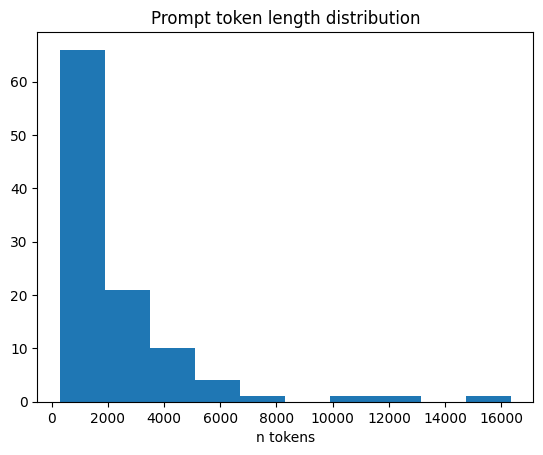

In [37]:
if not is_dry_run:
    #prompt_creator = FewShotPromptCreator(GridCodeBlockEncoder(MinimalGridEncoder()))
    #prompt_creator = SimplePromptCreator(GridCodeBlockEncoder(MinimalGridEncoder()))
    prompt_creator = SimplePromptCreator(GridCodeBlockEncoder(GridWithSeparationEncoder('|')))
    print_sample_prompt(data, prompt_creator)
    plot_input_token_length_distribution(data, prompt_creator)

In [38]:
if is_dry_run:
    with open('submission.json', 'w') as f:
        json.dump(dict(dry_run=True), f)
else:
    sampling_params = SamplingParams(**cfg.sampling_params)
    solutions, texts = inference(data, prompt_creator, sampling_params)
    with open('submission.json', 'w') as f:
        json.dump(solutions, f)    

  0%|          | 0/100 [00:00<?, ?it/s]


Processed prompts: 100%|██████████| 1/1 [00:08<00:00,  8.02s/it, est. speed input: 134.02 toks/s, output: 21.07 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.57s/it, est. speed input: 163.58 toks/s, output: 25.72 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:32<00:00, 32.21s/it, est. speed input: 121.14 toks/s, output: 25.06 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:28<00:00, 28.55s/it, est. speed input: 136.64 toks/s, output: 24.06 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it, est. speed input: 156.57 toks/s, output: 25.04 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 173.35 toks/s, output: 25.24 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:08<00:00,  8.14s/it, est. speed input: 133.11 toks/s, output: 25.44 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:08<00:00,  8.07s/it, est. speed input: 134.18 toks/s, output: 25.65 toks/s]

Processed prompts: 100%|███████

Exception when parsing response from 06df4c85: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (18,) + inhomogeneous part.



Processed prompts: 100%|██████████| 1/1 [00:39<00:00, 39.98s/it, est. speed input: 182.52 toks/s, output: 22.41 toks/s]


Exception when parsing response from 06df4c85: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (18,) + inhomogeneous part.



Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.64s/it, est. speed input: 135.65 toks/s, output: 25.44 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.62s/it, est. speed input: 136.18 toks/s, output: 25.54 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:11<00:00, 11.07s/it, est. speed input: 208.97 toks/s, output: 24.48 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:10<00:00, 10.30s/it, est. speed input: 224.54 toks/s, output: 24.17 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:11<00:00, 11.59s/it, est. speed input: 132.13 toks/s, output: 25.46 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:11<00:00, 11.58s/it, est. speed input: 132.24 toks/s, output: 25.48 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:24<00:00, 24.88s/it, est. speed input: 158.10 toks/s, output: 24.16 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:20<00:00, 20.69s/it, est. speed input: 190.13 toks/s, output: 23.74 toks/s]

Processed prompts: 100%|███████

Exception when parsing response from 10fcaaa3: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (18,) + inhomogeneous part.



Processed prompts: 100%|██████████| 1/1 [00:08<00:00,  8.33s/it, est. speed input: 181.67 toks/s, output: 24.85 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:08<00:00,  8.34s/it, est. speed input: 181.52 toks/s, output: 24.83 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, est. speed input: 1439.02 toks/s, output: 9.97 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, est. speed input: 1658.71 toks/s, output: 7.50 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it, est. speed input: 829.77 toks/s, output: 18.28 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it, est. speed input: 832.67 toks/s, output: 18.34 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.35s/it, est. speed input: 175.87 toks/s, output: 24.89 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.32s/it, est. speed input: 176.73 toks/s, output: 25.01 toks/s]

Processed prompts: 100%|███████

Exception when parsing response from 1c786137: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (125,) + inhomogeneous part.



Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.36s/it, est. speed input: 462.04 toks/s, output: 21.24 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:08<00:00,  8.18s/it, est. speed input: 136.11 toks/s, output: 25.31 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:08<00:00,  8.08s/it, est. speed input: 137.72 toks/s, output: 25.61 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it, est. speed input: 887.65 toks/s, output: 17.27 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it, est. speed input: 932.45 toks/s, output: 16.69 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 207.86 toks/s, output: 25.16 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 207.51 toks/s, output: 25.11 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:24<00:00, 24.50s/it, est. speed input: 169.78 toks/s, output: 23.88 toks/s]

Processed prompts: 100%|███████

WARNING 11-05 22:55:51 scheduler.py:699] Input prompt (12713 tokens) is too long and exceeds limit of 8192


Processed prompts: 100%|██████████| 1/1 [00:00<00:00, 787.81it/s, est. speed input: 10973901.37 toks/s, output: 0.00 toks/s]


Exception when parsing response from 264363fd: list index out of range



Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 11-05 22:55:51 scheduler.py:699] Input prompt (12713 tokens) is too long and exceeds limit of 8192


Processed prompts: 100%|██████████| 1/1 [00:00<00:00, 875.45it/s, est. speed input: 12780965.19 toks/s, output: 0.00 toks/s]


Exception when parsing response from 264363fd: list index out of range



Processed prompts: 100%|██████████| 1/1 [00:20<00:00, 20.61s/it, est. speed input: 128.19 toks/s, output: 25.09 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:20<00:00, 20.62s/it, est. speed input: 128.09 toks/s, output: 25.07 toks/s]

Processed prompts: 100%|██████████| 3/3 [00:00<00:00,  3.90it/s, est. speed input: 1399.99 toks/s, output: 35.10 toks/s][A

Processed prompts: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s, est. speed input: 1394.98 toks/s, output: 34.97 toks/s][A

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it, est. speed input: 389.64 toks/s, output: 22.86 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 350.01 toks/s, output: 23.40 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:19<00:00, 19.35s/it, est. speed input: 164.43 toks/s, output: 24.55 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:27<00:00, 27.63s/it, est. speed input: 115.14 toks/s, output: 25.01 toks/s]

Processed prompts: 100%|█

WARNING 11-05 23:03:34 scheduler.py:699] Input prompt (16335 tokens) is too long and exceeds limit of 8192


Processed prompts: 100%|██████████| 1/1 [00:00<00:00, 767.63it/s, est. speed input: 14555758.62 toks/s, output: 0.00 toks/s]


Exception when parsing response from 3631a71a: list index out of range



Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 11-05 23:03:35 scheduler.py:699] Input prompt (16335 tokens) is too long and exceeds limit of 8192


Processed prompts: 100%|██████████| 1/1 [00:00<00:00, 529.99it/s, est. speed input: 13936931.62 toks/s, output: 0.00 toks/s]


Exception when parsing response from 3631a71a: list index out of range



Processed prompts: 100%|██████████| 1/1 [00:09<00:00,  9.68s/it, est. speed input: 180.86 toks/s, output: 24.89 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:09<00:00,  9.67s/it, est. speed input: 181.14 toks/s, output: 24.93 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:17<00:00, 17.12s/it, est. speed input: 149.58 toks/s, output: 24.94 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:17<00:00, 17.17s/it, est. speed input: 149.14 toks/s, output: 24.87 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:25<00:00, 25.31s/it, est. speed input: 148.14 toks/s, output: 24.46 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:25<00:00, 25.31s/it, est. speed input: 148.13 toks/s, output: 24.46 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:08<00:00,  8.31s/it, est. speed input: 182.07 toks/s, output: 24.91 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:09<00:00,  9.11s/it, est. speed input: 166.13 toks/s, output: 24.92 toks/s]

Processed prompts: 100%|███████

WARNING 11-05 23:05:40 scheduler.py:699] Input prompt (9931 tokens) is too long and exceeds limit of 8192


Processed prompts: 100%|██████████| 1/1 [00:00<00:00, 883.01it/s, est. speed input: 9800854.83 toks/s, output: 0.00 toks/s]


Exception when parsing response from 39e1d7f9: list index out of range



Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 11-05 23:05:40 scheduler.py:699] Input prompt (9931 tokens) is too long and exceeds limit of 8192


Processed prompts: 100%|██████████| 1/1 [00:00<00:00, 852.33it/s, est. speed input: 9557969.95 toks/s, output: 0.00 toks/s]


Exception when parsing response from 39e1d7f9: list index out of range



Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.08s/it, est. speed input: 142.33 toks/s, output: 25.72 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.11s/it, est. speed input: 141.51 toks/s, output: 25.57 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.87s/it, est. speed input: 109.63 toks/s, output: 25.75 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.86s/it, est. speed input: 109.84 toks/s, output: 25.79 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.19s/it, est. speed input: 95.78 toks/s, output: 26.02 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 187.60 toks/s, output: 25.29 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:08<00:00,  8.31s/it, est. speed input: 173.91 toks/s, output: 24.91 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:08<00:00,  8.30s/it, est. speed input: 174.26 toks/s, output: 24.96 toks/s]

Processed prompts: 100%|████████

Exception when parsing response from 40853293: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (50,) + inhomogeneous part.



Processed prompts: 100%|██████████| 1/1 [00:32<00:00, 32.67s/it, est. speed input: 125.23 toks/s, output: 24.70 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:16<00:00, 16.24s/it, est. speed input: 175.92 toks/s, output: 24.57 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:16<00:00, 16.28s/it, est. speed input: 175.50 toks/s, output: 24.51 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:18<00:00, 18.02s/it, est. speed input: 129.89 toks/s, output: 25.36 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:18<00:00, 18.03s/it, est. speed input: 129.86 toks/s, output: 25.35 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.61s/it, est. speed input: 136.43 toks/s, output: 25.59 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.61s/it, est. speed input: 136.39 toks/s, output: 25.58 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:23<00:00, 23.14s/it, est. speed input: 130.12 toks/s, output: 24.94 toks/s]

Processed prompts: 100%|███████

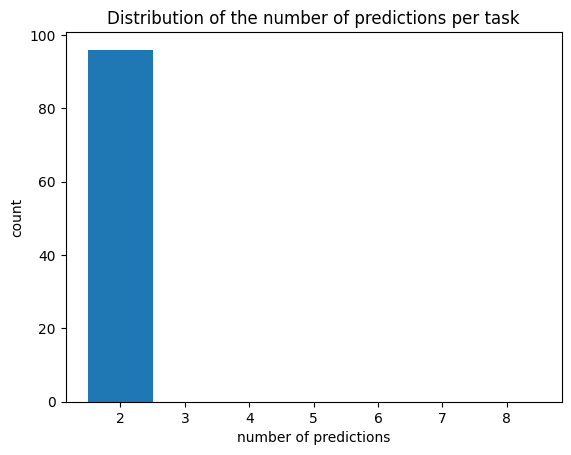

In [39]:
if not is_dry_run:
    number_of_predictions_per_task = analyze_number_of_predictions_per_task(data, texts)
    number_of_predictions_per_task

## Evaluation

In [40]:
ground_truth_path = cfg.dataset_path.replace('challenges.json', 'solutions.json')
if os.path.exists(ground_truth_path):
    with open(ground_truth_path, 'r') as f:
        ground_truth = json.load(f)
    ground_truth = {key: ground_truth[key] for key in solutions}
    evaluate(ground_truth, solutions)
    
    with open('texts.json', 'w') as f:
        json.dump(texts, f)
    with open('number_of_predictions_per_task.json', 'w') as f:
        json.dump(number_of_predictions_per_task, f)

# New methods: Data argumentation

## TODO

- [x] Do I have to apply the chat template before calling the model? Yes
- [x] Implement a simple formatter and parser to go from ARC format to text and viceversa
- [x] Function to format a sample and to parse the output
- [x] Verify that the tokenizer does encode each cell independently. Using the tokenizer vocabulary I have verified that each number appears only once, thus separation between numbers is not necessary.
- [x] Make inference in a whole dataset
- [x] Evaluate dataset, I would like to see statistics about failed predictions and accuracy
- [x] Visualization of the predictions
- [x] Add a configuration object
- [ ] Add logging
- [x] Show a promtp as example
- [x] Show the full task as reference
- [x] Sampling parameters to configuration
- [x] Improve saving of the metrics
- [x] First evaluations with a smaller subset
- [x] Token length distribution
- [x] Dry run for submission, check on previous competitions how it is done. https://www.kaggle.com/discussions/product-feedback/315792
- [x] Measure the number of predictions per task
- [x] Better metrics
- [x] Few shot prompts